In [ ]:
%pip install -r requirements.txt

In [8]:
from transformers import CLIPModel, CLIPTokenizer, CLIPImageProcessor, AutoModelForCausalLM, AutoTokenizer
from PIL import Image
import torch
import torch.nn as nn


device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")


clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
vision_encoder = clip_model.vision_model
text_encoder = clip_model.text_model
image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

qwen_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen3-0.6B-Base")
qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B-Base")



Using device: mps


In [21]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, clip_model, vision_encoder, qwen_model, adapter, qwen_tokenizer):
        super().__init__()
        self.clip_model = clip_model
        self.vision_encoder = vision_encoder
        self.qwen_model = qwen_model
        self.adapter = adapter
        self.text_encoder = text_encoder
        self.qwen_tokenizer = qwen_tokenizer

    def forward(self, image, text_input=None, max_length=50):
        # Process image through CLIP vision encoder
        vision_output = self.vision_encoder(image)
        image_features = vision_output.pooler_output
        
        # Linear projection (CLIP's visual projection)
        image_features_proj = self.clip_model.visual_projection(image_features)
        
        # Adapter processes the projected image features
        image_latent = self.adapter(image_features_proj)
        
        # Add sequence dimension to image_latent to match text_embeddings
        image_latent = image_latent.unsqueeze(1)  # [batch_size, 1, hidden_dim]
        
        # If no text input provided, create a simple prompt
        if text_input is None:
            text_input = "Describe this image:"
        
        # Tokenize the text input
        text_tokens = self.qwen_tokenizer(text_input, return_tensors="pt")
        text_embeddings = self.qwen_model.model.embed_tokens(text_tokens.input_ids)
        
        # Concatenate image features with text embeddings
        combined_embeddings = torch.cat([image_latent, text_embeddings], dim=1)
        
        # Create attention mask for the combined sequence
        image_seq_len = image_latent.size(1)
        text_seq_len = text_embeddings.size(1)
        attention_mask = torch.ones((1, image_seq_len + text_seq_len))
        
        # Create position IDs
        position_ids = torch.arange(image_seq_len + text_seq_len).unsqueeze(0)
        
        # Generate using Qwen model
        outputs = self.qwen_model(
            inputs_embeds=combined_embeddings,
            attention_mask=attention_mask,
            position_ids=position_ids,
            max_length=max_length,
            do_sample=True,
            temperature=0.7,
            pad_token_id=self.qwen_tokenizer.pad_token_id,
            eos_token_id=self.qwen_tokenizer.eos_token_id,
        )
        
        return outputs

In [54]:
clip_dim = clip_model.visual_projection.out_features
qwen_dim = qwen_model.model.embed_tokens.embedding_dim

adapter = nn.Sequential(
    nn.Linear(clip_dim, qwen_dim),
    nn.LayerNorm(qwen_dim),
    nn.GELU(),
    nn.Linear(qwen_dim, qwen_dim),
)

model = ImageCaptioningModel(clip_model, vision_encoder, qwen_model, adapter, qwen_tokenizer)
model.eval()

import torchvision.transforms as transforms

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image
image_path = "images/cat.jpg"
image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Now test the model
# Now test the model
with torch.no_grad():
    # Test with just image
    outputs = model(image_tensor, text_input="A photo of")
    
    # Extract logits from the output
    if hasattr(outputs, 'logits'):
        logits = outputs.logits
        # Get the predicted token IDs
        generated_ids = torch.argmax(logits, dim=-1)
    else:
        # If it's already a tensor
        generated_ids = outputs
    
    # Convert to list for tokenizer
    if isinstance(generated_ids, torch.Tensor):
        generated_ids = generated_ids.tolist()
    
    # Handle batch dimension - take first sequence
    if isinstance(generated_ids[0], list):
        generated_ids = generated_ids[0]
    
    generated_caption = qwen_tokenizer.decode(generated_ids, skip_special_tokens=True)
    print("Generated caption:", generated_caption)

Generated caption:  carbonatehan of a


Generated caption: waterheiroAquaFestival, which is the third in the series of three Aquariums that will be built in the future.
A: In a

Processing: images/cat.jpg


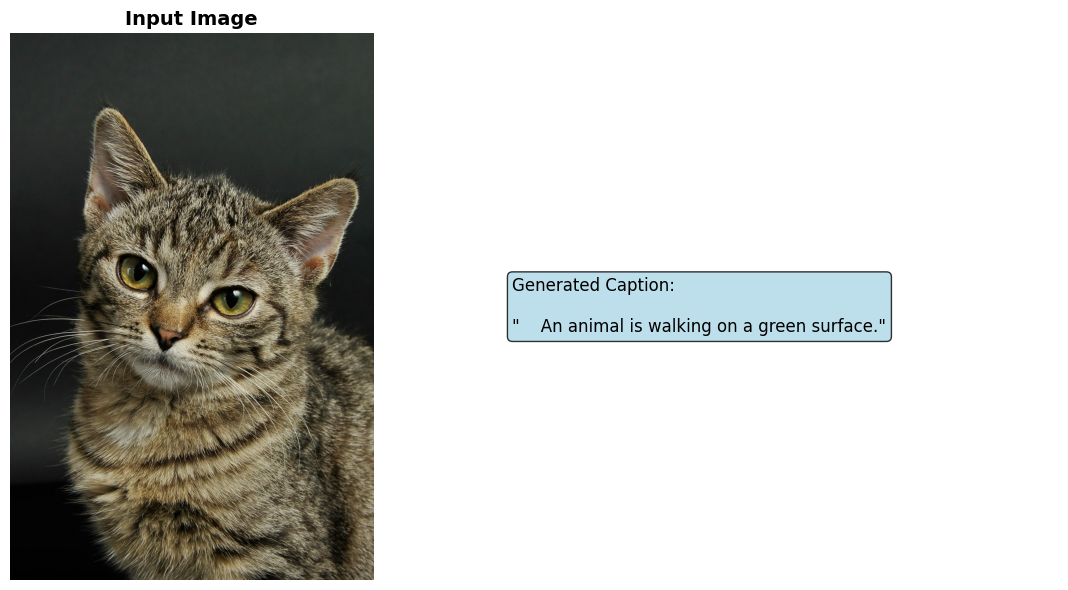

Caption:     An animal is walking on a green surface.

Processing: images/dog.jpg


) missing from font(s) DejaVu Sans._4l640000gn/T/ipykernel_48487/353814733.py:118: UserWarning: Glyph 13 (
  plt.tight_layout()


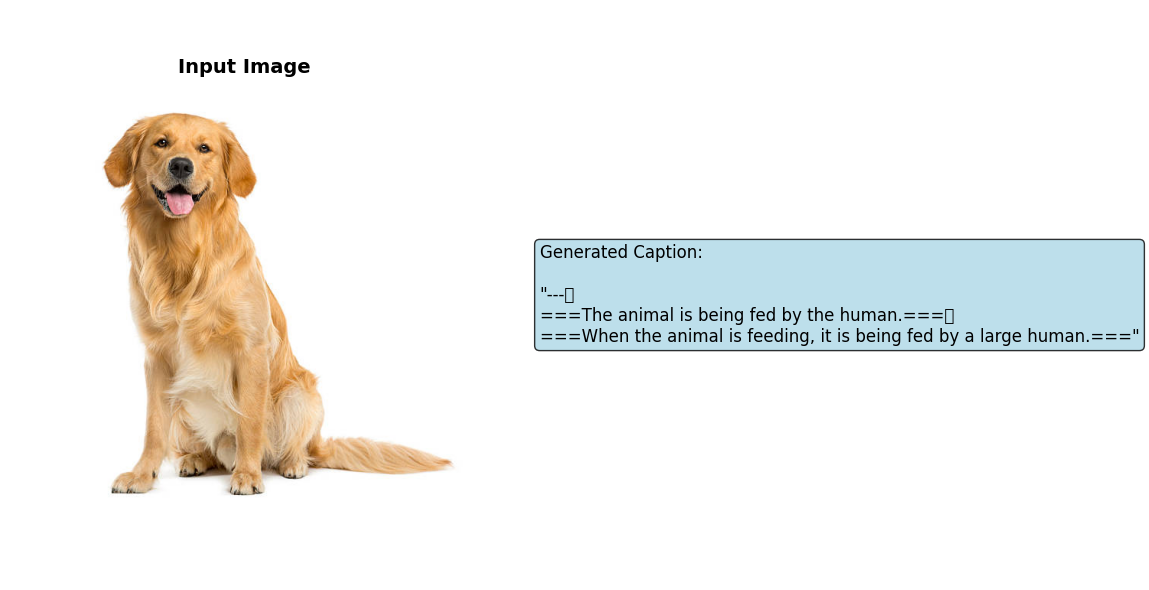

Caption: ---
===The animal is being fed by the human.===
===When the animal is feeding, it is being fed by a large human.===

Processing: images/bird.jpg


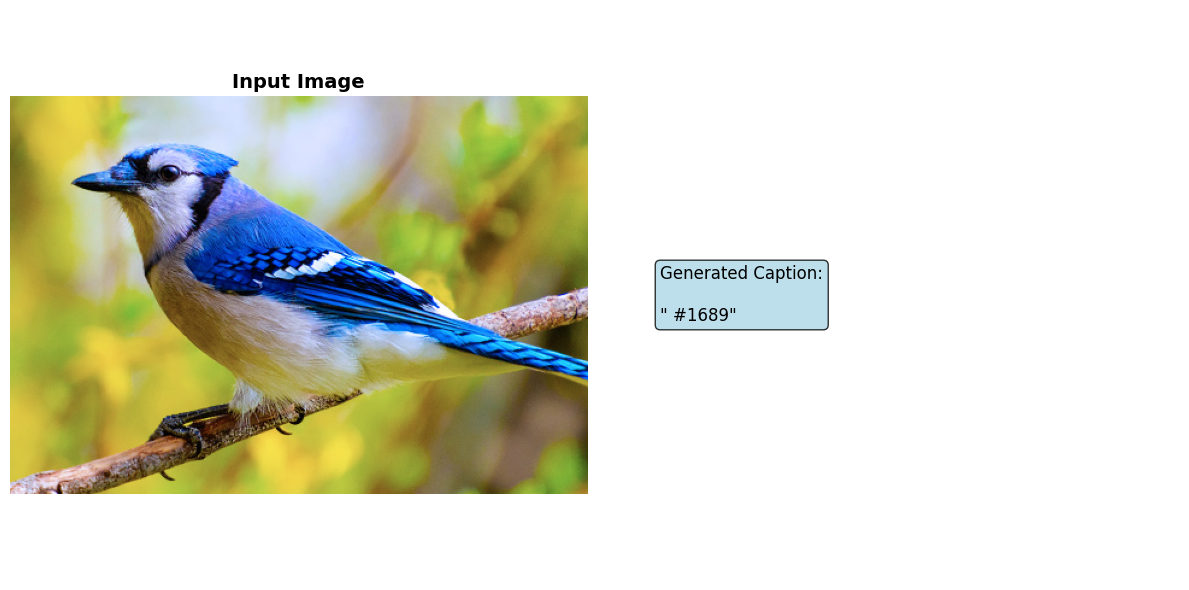

Caption:  #1689

Processing: images/car.jpg


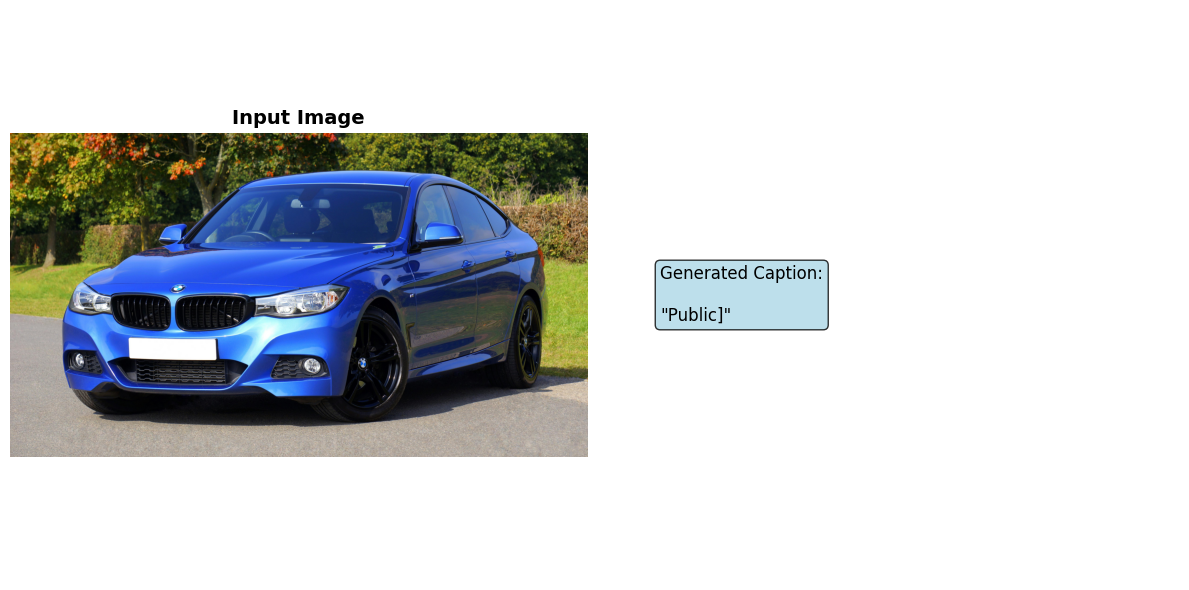

Caption: Public]

Processing: images/house.jpg


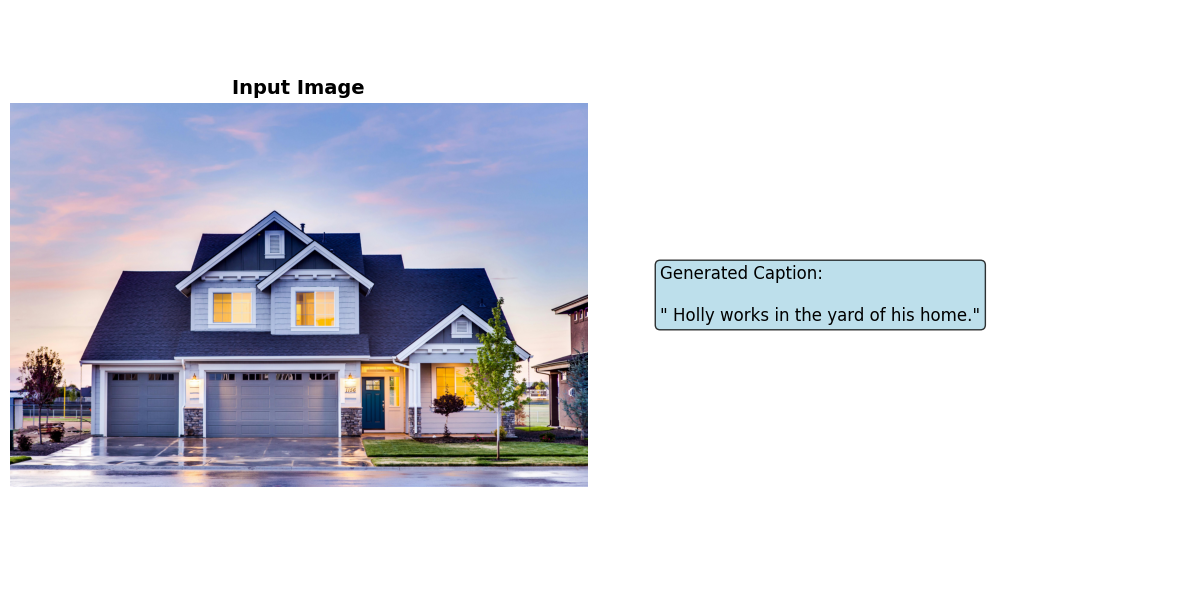

Caption:  Holly works in the yard of his home.


In [ ]:
# ... existing code ...

class ImageCaptioningModel(nn.Module):
    def __init__(self, clip_model, vision_encoder, qwen_model, adapter, qwen_tokenizer):
        super().__init__()
        self.clip_model = clip_model
        self.vision_encoder = vision_encoder
        self.qwen_model = qwen_model
        self.adapter = adapter
        self.text_encoder = text_encoder
        self.qwen_tokenizer = qwen_tokenizer

    def encode_image(self, image):
        # Process image through CLIP vision encoder
        vision_output = self.vision_encoder(image)
        image_features = vision_output.pooler_output
        
        # Linear projection (CLIP's visual projection)
        image_features_proj = self.clip_model.visual_projection(image_features)
        
        # Adapter processes the projected image features
        image_latent = self.adapter(image_features_proj)
        
        return image_latent

    def generate(self, image, max_length=50):
        # Encode image through adapter
        image_latent = self.encode_image(image)
        image_latent = image_latent.unsqueeze(1)  # [batch_size, 1, hidden_dim]
        
        # Start with BOS token
        start_token = self.qwen_tokenizer.bos_token_id
        if start_token is None:
            start_token = self.qwen_tokenizer.pad_token_id
        
        input_ids = torch.tensor([[start_token]])
        text_embeddings = self.qwen_model.model.embed_tokens(input_ids)
        
        # Concatenate adapted image features with text embeddings (PaLiGemma style)
        combined_embeddings = torch.cat([image_latent, text_embeddings], dim=1)
        
        # Create attention mask
        attention_mask = torch.ones((1, combined_embeddings.size(1)))
        
        # Generate using the combined embeddings
        outputs = self.qwen_model.generate(
            inputs_embeds=combined_embeddings,
            attention_mask=attention_mask,
            max_new_tokens=max_length,
            do_sample=True,
            temperature=0.7,
            pad_token_id=self.qwen_tokenizer.pad_token_id,
            eos_token_id=self.qwen_tokenizer.eos_token_id,
        )
        
        return outputs

# ... existing code ...

adapter.load_state_dict(torch.load('adapter_trained.pth'))

# Set to evaluation mode
adapter.eval()

model = ImageCaptioningModel(clip_model, vision_encoder, qwen_model, adapter, qwen_tokenizer)
model.eval()


# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image
image_path = "images/cat.jpg"
image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Now test the model
with torch.no_grad():
    # Generate caption from just the image
    generated_ids = model.generate(image_tensor, max_length=30)
    generated_caption = qwen_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print("Generated caption:", generated_caption)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def create_advanced_meme(image_path, caption, output_path=None):
    """Create an advanced meme with better text positioning"""
    # Load image
    image = Image.open(image_path).convert('RGB')
    
    # Resize to meme dimensions
    image = image.resize((800, 600), Image.Resampling.LANCZOS)
    
    # Create a copy for drawing
    img_with_text = image.copy()
    draw = ImageDraw.Draw(img_with_text)
    
    # Try different fonts
    font_size = 50
    try:
        font = ImageFont.truetype("/System/Library/Fonts/Arial Bold.ttf", font_size)
    except:
        try:
            font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", font_size)
        except:
            font = ImageFont.load_default()
    
    # Split caption into lines if too long
    words = caption.split()
    lines = []
    current_line = ""
    
    for word in words:
        test_line = current_line + " " + word if current_line else word
        bbox = draw.textbbox((0, 0), test_line, font=font)
        if bbox[2] - bbox[0] > image.width - 40:  # 40px margin
            if current_line:
                lines.append(current_line)
                current_line = word
            else:
                lines.append(word)
        else:
            current_line = test_line
    
    if current_line:
        lines.append(current_line)
    
    # Calculate total text height
    total_height = 0
    for line in lines:
        bbox = draw.textbbox((0, 0), line, font=font)
        total_height += bbox[3] - bbox[1]
    
    # Position text at bottom
    img_width, img_height = image.size
    y = img_height - total_height - 30  # 30px from bottom
    
    # Draw each line
    for line in lines:
        bbox = draw.textbbox((0, 0), line, font=font)
        text_width = bbox[2] - bbox[0]
        x = (img_width - text_width) // 2
        
        # Add black outline
        outline_width = 4
        for dx in range(-outline_width, outline_width + 1):
            for dy in range(-outline_width, outline_width + 1):
                draw.text((x + dx, y + dy), line, font=font, fill='black')
        
        # Add white text
        draw.text((x, y), line, font=font, fill='white')
        
        # Move to next line
        y += bbox[3] - bbox[1] + 5
    
    # Display
    plt.figure(figsize=(12, 9))
    plt.imshow(img_with_text)
    plt.axis('off')
    plt.title(f'Meme: {image_path}', fontsize=14, fontweight='bold')
    plt.show()
    
    # Save if output path provided
    if output_path:
        img_with_text.save(output_path)
        print(f"Saved meme to: {output_path}")
    
    return img_with_text

# Test the advanced meme creator
test_images = [
    "images/cat.jpg",
    "images/dog.jpg", 
    "images/bird.jpg",
    "images/car.jpg",
    "images/house.jpg"
]

for image_path in test_images:
    print(f"\nCreating meme for: {image_path}")
    
    # Generate caption
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    
    with torch.no_grad():
        generated_ids = model.generate(image_tensor, max_length=30)
        generated_caption = qwen_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    
    # Create meme
    meme = create_advanced_meme(image_path, generated_caption)
    print(f"Caption: {generated_caption}")

In [85]:
# ... existing code ...

# Load Flickr30k dataset and check available splits
from datasets import load_dataset
dataset = load_dataset("nlphuji/flickr30k")

# Check what splits are available
print("Available splits:", dataset.keys())

# Use the correct split name (usually 'train' or 'training')
# Let's try different common split names
if 'train' in dataset:
    train_split = 'train'
elif 'training' in dataset:
    train_split = 'training'
else:
    # Use the first available split
    train_split = list(dataset.keys())[0]

print(f"Using split: {train_split}")

# Create training mode
class TrainingModel(nn.Module):
    def __init__(self, clip_model, vision_encoder, qwen_model, adapter, qwen_tokenizer):
        super().__init__()
        self.clip_model = clip_model
        self.vision_encoder = vision_encoder
        self.qwen_model = qwen_model
        self.adapter = adapter
        self.qwen_tokenizer = qwen_tokenizer

    def forward(self, image, caption):
        # Encode image through adapter
        image_latent = self.encode_image(image)
        image_latent = image_latent.unsqueeze(1)  # [batch_size, 1, hidden_dim]
        
        # Tokenize caption
        inputs = self.qwen_tokenizer(caption, return_tensors="pt", padding=True, truncation=True)
        text_embeddings = self.qwen_model.model.embed_tokens(inputs.input_ids)
        
        # Ensure both tensors have the same batch size
        if image_latent.size(0) != text_embeddings.size(0):
            # Use the smaller batch size and truncate both
            min_batch_size = min(image_latent.size(0), text_embeddings.size(0))
            image_latent = image_latent[:min_batch_size]
            text_embeddings = text_embeddings[:min_batch_size]
            inputs.input_ids = inputs.input_ids[:min_batch_size]
        
        # Concatenate image and text embeddings
        combined_embeddings = torch.cat([image_latent, text_embeddings], dim=1)
        
        # Create attention mask for the combined sequence
        attention_mask = torch.ones((combined_embeddings.size(0), combined_embeddings.size(1)))
        
        # Create labels that match the combined embeddings
        # We need to create labels that correspond to the text part only
        image_seq_len = image_latent.size(1)
        text_seq_len = text_embeddings.size(1)
        
        # Create labels: -100 for image tokens (ignore in loss), actual tokens for text
        labels = torch.full((combined_embeddings.size(0), combined_embeddings.size(1)), -100)
        labels[:, image_seq_len:] = inputs.input_ids
        
        # Forward pass
        outputs = self.qwen_model(
            inputs_embeds=combined_embeddings,
            attention_mask=attention_mask,
            labels=labels
        )
        
        return outputs.loss

    def encode_image(self, image):
        vision_output = self.vision_encoder(image)
        image_features = vision_output.pooler_output
        image_features_proj = self.clip_model.visual_projection(image_features)
        image_latent = self.adapter(image_features_proj)
        return image_latent

# Create training model
training_model = TrainingModel(clip_model, vision_encoder, qwen_model, adapter, qwen_tokenizer)

# Setup optimizer (only for adapter)
optimizer = torch.optim.AdamW(adapter.parameters(), lr=1e-4)

def train_step(batch):
    images = batch['image']
    captions = batch['caption']
    
    # Convert PIL images to tensors
    if isinstance(images, list):
        # Handle batch of images
        processed_images = []
        for img in images:
            if hasattr(img, 'convert'):
                # PIL Image
                img = img.convert('RGB')
                img = transform(img).unsqueeze(0)
            processed_images.append(img)
        images = torch.cat(processed_images, dim=0)
    else:
        # Single image
        if hasattr(images, 'convert'):
            images = images.convert('RGB')
            images = transform(images).unsqueeze(0)
    
    loss = training_model(images, captions)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    total_loss = 0
    for i, batch in enumerate(dataset[train_split]):
        if i >= 1000:  # Limit for testing
            break
        loss = train_step(batch)
        total_loss += loss
        
        if i % 100 == 0:
            print(f"Epoch {epoch}, Step {i}, Loss: {loss:.4f}")
    
    avg_loss = total_loss / min(1000, len(dataset[train_split]))
    print(f"Epoch {epoch} completed. Average loss: {avg_loss:.4f}")

# Save the trained adapter
torch.save(adapter.state_dict(), 'adapter_trained.pth')

Available splits: dict_keys(['test'])
Using split: test
Epoch 0, Step 0, Loss: 4.2937
Epoch 0, Step 100, Loss: 5.1693
Epoch 0, Step 200, Loss: 3.5517
Epoch 0, Step 300, Loss: 3.1578
Epoch 0, Step 400, Loss: 3.9118
Epoch 0, Step 500, Loss: 5.4975
Epoch 0, Step 600, Loss: 2.2207
Epoch 0, Step 700, Loss: 2.9100
Epoch 0, Step 800, Loss: 4.3870
Epoch 0, Step 900, Loss: 4.3747
Epoch 0 completed. Average loss: 3.4157
Epoch 1, Step 0, Loss: 2.8646
Epoch 1, Step 100, Loss: 3.2375
Epoch 1, Step 200, Loss: 3.0284
Epoch 1, Step 300, Loss: 3.0595
Epoch 1, Step 400, Loss: 3.6537
Epoch 1, Step 500, Loss: 5.0191
Epoch 1, Step 600, Loss: 2.1869
Epoch 1, Step 700, Loss: 2.7947
Epoch 1, Step 800, Loss: 4.1611
Epoch 1, Step 900, Loss: 4.0405
Epoch 1 completed. Average loss: 2.9754
Epoch 2, Step 0, Loss: 2.6771
Epoch 2, Step 100, Loss: 2.9953
Epoch 2, Step 200, Loss: 2.9293
Epoch 2, Step 300, Loss: 2.9673
Epoch 2, Step 400, Loss: 3.4172
Epoch 2, Step 500, Loss: 4.8493
Epoch 2, Step 600, Loss: 2.0301
Epoch 